# 3D Deconvolution Benchmark: Julia

---
## Setup

In [1]:
using DeconvOptim, Images, FFTW, Noise, ImageView, BenchmarkTools, Plots

---
## Test Image



In [106]:
img = convert(Array{Float32}, channelview(load("simple_3d_ball.tif")));

In [120]:
psf = ifftshift(convert(Array{Float32}, channelview(load("simple_3d_psf.tif"))));

In [108]:
# psf ./= sum(psf)
# # create a blurred, noisy version of that image
# img_b = conv(img, psf, [1, 2, 3])
# img_n = poisson(img_b, 300);
# save("simple_3d_ball_blurred.tif", img_n)

In [121]:
println("Max value in psf: ", maximum(psf))
println("Min value in psf: ", minimum(psf))

# Agregar un pequeño valor para evitar divisiones por cero
epsilon = eps(Float32)

# Asegurarse de que el PSF no tenga valores cero y normalizarlo
psf = psf .+ epsilon;
psf ./= sum(psf);


Max value in psf: 1.0
Min value in psf: 0.0


In [110]:
img_n = convert(Array{Float32}, channelview(load("simple_3d_ball_blurred.tif")));

In [111]:
println(size(img_n))
println("img_n element type: ", eltype(img_n))
println(size(psf))
println("psf element type: ", eltype(psf))

(64, 64, 64)
img_n element type: Float32
(64, 64, 64)
psf element type: Float32


In [112]:
reg = TV(num_dims=3, sum_dims=[1, 2, 3]);

In [113]:
res2 = richardson_lucy_iterative(img_n, psf, regularizer=reg, iterations=30);
println(size(res2))
println("res2 element type: ", eltype(res2))

(64, 64, 64)
res2 element type: Float32


In [114]:
@benchmark richardson_lucy_iterative(img_n, psf, regularizer=reg, iterations=30)  samples=100 evals=1

BenchmarkTools.Trial: 57 samples with 1 evaluation.
 Range (min … max):  84.689 ms … 91.357 ms  ┊ GC (min … max): 0.00% … 1.03%
 Time  (median):     86.982 ms              ┊ GC (median):    1.14%
 Time  (mean ± σ):   87.028 ms ±  1.465 ms  ┊ GC (mean ± σ):  1.03% ± 1.10%

   ▁▁     █  ▁ ▄▄ ▁  ▄ █▁ ▄▁ ▄  █ ▁                            
  ▆██▁▆▁▁▆█▆▁█▁██▆█▆▆█▁██▁██▁█▁▁█▆█▁▆▁▆▁▆▁▁▆▁▁▁▆▁▁▁▁▁▁▁▆▁▁▁▁▆ ▁
  84.7 ms         Histogram: frequency by time          91 ms <

 Memory estimate: 38.15 MiB, allocs estimate: 1894.

In [115]:
res = richardson_lucy_iterative(img_n, psf, regularizer=nothing, iterations=30);

println(size(res))
println("res element type: ", eltype(res))

(64, 64, 64)
res element type: Float32


In [116]:
@benchmark richardson_lucy_iterative(img_n, psf, regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  45.966 ms …  51.688 ms  ┊ GC (min … max): 0.00% … 10.38%
 Time  (median):     46.249 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   46.481 ms ± 804.278 μs  ┊ GC (mean ± σ):  0.51% ±  1.57%

  ▄▂█▄▃▄▂                                                       
  ███████▇▃▁▃▃▃▃▁▁▁▁▁▁▁▁▁▁▅▄▁▃▁▁▃▄▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  46 ms           Histogram: frequency by time         49.9 ms <

 Memory estimate: 7.10 MiB, allocs estimate: 33.

In [117]:
# Verificar valores mínimos y máximos en las matrices resultantes
println("Max value in res2: ", maximum(res2))
println("Min value in res2: ", minimum(res2))
println("Max value in res: ", maximum(res))
println("Min value in res: ", minimum(res))
println("Max value in img_n: ", maximum(img_n))
println("Min value in img_n: ", minimum(img_n))


Max value in res2: 0.41446292
Min value in res2: -0.0
Max value in res: 0.5674032
Min value in res: 0.0
Max value in img_n: 0.2627451
Min value in img_n: 0.0


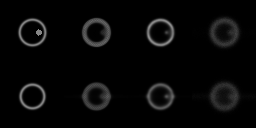

In [118]:
img_comb1 = [img[:, : ,32] res2[:, :, 32] res[:, :, 32] img_n[:, :, 32]]
img_comb2 = [img[:, : ,38] res2[:, :, 38] res[:, :, 38] img_n[:, :, 38]]

img_comb = cat(img_comb1, img_comb2, dims=1)
#img_comb ./= maximum(img_comb)

#imshow([img[:, :, 20:end] res2[:, :, 20:end] res[:, :, 20:end] img_n[:, :, 20:end]])
colorview(Gray, img_comb)

---
## Cell 3D

In [24]:
cell = convert(Array{Float32}, channelview(load("cells3d_convolved.tiff")));

In [25]:
cell_psf = convert(Array{Float32}, channelview(load("cells3d_psf.tiff")));

In [26]:
cell /= maximum(cell);
cell_psf /= maximum(cell_psf);

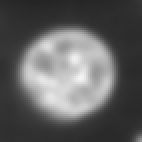

In [27]:
colorview(Gray, cell[:,:,30])

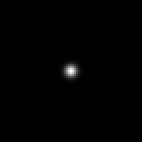

In [28]:
colorview(Gray, cell_psf[:,:,30])

In [29]:
cell_res, cell_ores = deconvolution(cell, ifftshift(cell_psf), regularizer=nothing, iterations=10);

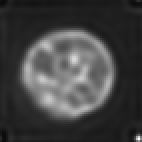

In [30]:
colorview(Gray, cell_res[:,:,30]/maximum(cell_res[:,:,30]))

In [31]:
@benchmark deconvolution(cell, ifftshift(cell_psf), regularizer=nothing, iterations=10) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  427.467 ms … 577.024 ms  ┊ GC (min … max): 0.07% … 23.21%
 Time  (median):     431.148 ms               ┊ GC (median):    0.51%
 Time  (mean ± σ):   436.169 ms ±  20.120 ms  ┊ GC (mean ± σ):  1.16% ±  3.25%

  ▇█                                                             
  ███▃▄▃▄▄▄▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  427 ms           Histogram: frequency by time          563 ms <

 Memory estimate: 105.90 MiB, allocs estimate: 2196.

---
## Cube of Spherical Beads

In [4]:
# Cargamos la imagen

cube = convert(Array{Float32}, channelview(load("cubeConvolved.tif")));

# Cargamos la psf

cubePSF = convert(Array{Float32}, channelview(load("PSF.tif")));

cube /= maximum(cube);
cubePSF /= maximum(cubePSF);

Loading: 100%|███████████████████████████████████████████| Time: 0:00:00


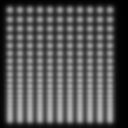

In [5]:
colorview(Gray, cube[:,:,30])

In [6]:
number_of_iterations = 30

cube_res, cube_ores = deconvolution(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations);

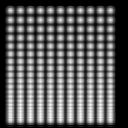

In [39]:
colorview(Gray, cube_res[:,:,30]/maximum(cube_res[:,:,30]))

In [8]:
deconCube = richardson_lucy_iterative(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations);

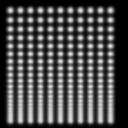

In [9]:
colorview(Gray, deconCube[:,:,30]/maximum(cube_res[:,:,30]))

In [64]:
@benchmark richardson_lucy_iterative(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations) samples=10 evals=1

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  628.420 ms … 637.643 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     629.719 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   630.658 ms ±   3.137 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █    ██ ██  █                                               █  
  █▁▁▁▁██▁██▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  628 ms           Histogram: frequency by time          638 ms <

 Memory estimate: 64.38 MiB, allocs estimate: 37.

---
## C. elegans embryo

In [140]:
import Pkg;

Pkg.add("FileIO")

   Resolving package versions...
  No Changes to `~/TFGNotebook/Project.toml`
  No Changes to `~/TFGNotebook/Manifest.toml`


Comprobación de cuantos núcleos está usando

In [3]:
using Distributed
println(nprocs())  # Debe devolver 1

1


In [2]:
using FileIO
using Images

function load_image_stack(folder_path::String)
    # Listar todos los archivos en la carpeta y ordenar
    files = sort(filter(f -> endswith(f, ".tif") || endswith(f, ".png") || endswith(f, ".jpg"), readdir(folder_path)))

    # Leer la primera imagen para obtener las dimensiones
    first_image = load(joinpath(folder_path, files[1]))
    height, width = size(first_image)

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = Array{Float32, 3}(undef, height, width,length(files))

    # Leer el rango de valores para normalización
    max_val = Float32(maximum(first_image)) # Valor máximo para normalización

    # Cargar cada imagen en la matriz 3D y convertir a Float32
    for (i, file) in enumerate(files)
        image = load(joinpath(folder_path, file))
        image_stack[:, :, i] = Float32.(image) / max_val
    end
    
    return image_stack
end


load_image_stack (generic function with 1 method)

Funcion RL

In [4]:
function richardson_lucy_iterative2(measured, psf; 
    psf_bp=nothing,
    regularizer=nothing,
    λ=0.05,
    iterations=100,
    conv_dims=1:ndims(psf),
    threshold = 0,
    progress = nothing)

otf, conv_temp = plan_conv(measured, psf, conv_dims) 
### Add options for PSF inizialization -> traditional, wiener, butterworth, and WB
### These methods actually change otf_conj, probably they should be added as additional functions
if psf_bp !== nothing
otf_conj, _ = plan_conv(measured, psf_bp, conv_dims) 
else
otf_conj = conj.(otf)
end
# initializer
rec =  map(x -> x >= threshold ? x : threshold, measured) 

# buffer for gradient
# we need Base.invokelatest because of world age issues with generated
# regularizers
buffer_grad =  let 
if !isnothing(regularizer)
Base.invokelatest(gradient, regularizer, rec)[1]
else
nothing
end
end

∇reg(x) = buffer_grad .= Base.invokelatest(gradient, regularizer, x)[1]

buffer = copy(measured)

iter_without_reg(rec) = begin
buffer .= measured ./ (conv_temp(rec, otf))
conv_temp(buffer, otf_conj)
end
iter_with_reg(rec) = buffer .= (iter_without_reg(rec) .- λ .* ∇reg(rec))

iter = isnothing(regularizer) ? iter_without_reg : iter_with_reg

# the loss function is only needed for logging, not for LR itself
loss(myrec) = begin
fwd = conv_temp(myrec, otf)
return sum(fwd .- measured .* log.(fwd))
end

# logging part
tmp_time = 0.0
if progress !== nothing
record_progress!(progress, rec, 0, loss(rec), 0.0, 1.0)
tmp_time=time()
end
code_time = 0.0

# do actual optimization
for i in 1:iterations
rec .*= iter(rec)
if progress !== nothing
# do not count the time for evaluating the loss here.
code_time += time() .- tmp_time
record_progress!(progress, copy(rec), i, loss(rec), code_time, 1.0)
tmp_time=time()
end
end

return rec
end

richardson_lucy_iterative2 (generic function with 1 method)

In [8]:
# Crear una matriz de unos de 5x5
imageStackT = ones(5, 5)

# Asignar valores a posiciones específicas
imageStackT[2, 2] = 2.5
imageStackT[3, 3] = 2.8
imageStackT[4, 4] = 2
imageStackT[2, 3] = 1.5
imageStackT[2, 4] = 2.5
imageStackT[3, 2] = 2.8
imageStackT
#imageStackT = imageStackT/sum(imageStackT)


5×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0
 1.0  2.5  1.5  2.5  1.0
 1.0  2.8  2.8  1.0  1.0
 1.0  1.0  1.0  2.0  1.0
 1.0  1.0  1.0  1.0  1.0

In [9]:
# Crear una matriz de ceros de 5x5
psfStackT = zeros(5, 5)

# Asignar el valor 1 a la posición (3,3)
psfStackT[3, 3] = 1
psfStackT[2, 2] = 1
psfStackT[2, 3] = 1
psfStackT[2, 4] = 1
psfStackT[3, 2] = 1
psfStackT[3, 4] = 1
psfStackT[4, 2] = 1
psfStackT[4, 3] = 1
psfStackT[4, 4] = 1
psfStackT

5×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [10]:
devonvTEST = richardson_lucy_iterative2(imageStackT, ifftshift(psfStackT), regularizer=nothing, iterations=50)

5×5 Matrix{Float64}:
 1.22391   0.297604   2.01193    0.751464  1.44046
 1.71185   2.40018    3.06463    0.68811   0.063972
 1.02798   0.452696   7.0543     0.918766  1.14357
 1.36272   1.99793    1.12076    1.306     0.257754
 0.150592  0.0164152  0.0290237  0.304646  2.30276

### Canal 1

In [5]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = "/Users/yi/TFGNotebook/CElegans-CY3"
psfPath = "/Users/yi/TFGNotebook/PSF-CElegans-CY3"

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[1:356, 1:336, :]
psf_stack = load_image_stack(psfPath)[179:534, 169:504,:] #mitad +152

#save("imagenOriginal_CANAL1.png", image_stack[52, :, :]/maximum(image_stack))

# Verificar las dimensiones de las matrices 3D
println(size(image_stack))
println("image_stack element type: ", eltype(image_stack))
println(size(psf_stack))
maximum(image_stack)
#image_stack[1:356, 1:336,52]

(356, 336, 104)
image_stack element type: Float32
(356, 336, 104)


1.2995099f0

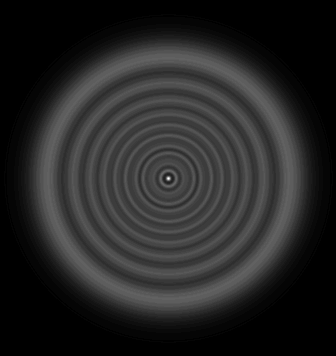

In [6]:
colorview(Gray, psf_stack[:,:,1]/maximum(psf_stack[:,:,1]))

In [7]:
num_iter = 50
canal1_res = richardson_lucy_iterative2(image_stack, ifftshift(psf_stack), regularizer=nothing, iterations=num_iter);

In [27]:
canal1_res[:,:,52]

356×336 Matrix{Float32}:
 0.101012   0.0997287  0.0987586  0.0999638  …  0.122636  0.120673  0.122447
 0.0997196  0.097231   0.0972496  0.0989065     0.119872  0.121787  0.118684
 0.0972237  0.0996199  0.0962593  0.0960546     0.117256  0.119265  0.121557
 0.0973346  0.0970962  0.0946115  0.0940927     0.120432  0.11973   0.116251
 0.0975271  0.0977241  0.0938007  0.0940991     0.119815  0.116866  0.115042
 0.0939958  0.0969037  0.0956936  0.0945297  …  0.122378  0.114525  0.117746
 0.0940002  0.0950524  0.0961309  0.093148      0.113247  0.118452  0.114113
 0.0948153  0.0955085  0.0943829  0.0929271     0.115364  0.111882  0.115509
 0.0908364  0.093042   0.0930613  0.0942105     0.112614  0.118171  0.1106
 0.0921176  0.0917563  0.0928987  0.0922398     0.112209  0.113297  0.110629
 ⋮                                           ⋱                      ⋮
 0.185788   0.18265    0.184906   0.187474      0.903492  0.873502  0.858226
 0.186171   0.181269   0.183511   0.17942       0.890948  0.

In [54]:
# Verificar las dimensiones y tipo de canal1_res
println("Tipo de canal1_res: ", typeof(canal1_res))
println("Dimensiones de canal1_res: ", size(canal1_res))

Tipo de canal1_res: Array{Float32, 3}
Dimensiones de canal1_res: (356, 336, 104)


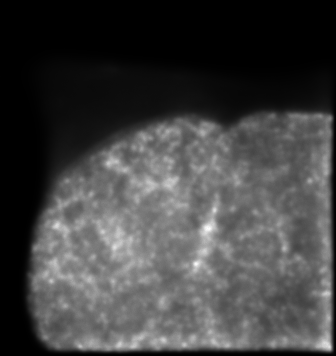

In [37]:
colorview(Gray, canal1_res[:,:,52]/maximum(canal1_res[:,:,52]))

In [8]:
save("Julia_CANAL1_50.png", canal1_res[:,:,52]/maximum(canal1_res[:,:,52]))

In [92]:
@benchmark richardson_lucy_iterative2(image_stack, ifftshift(psf_stack), regularizer=nothing, iterations=150) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 61.597 s (0.00% GC) to evaluate,
 with a memory estimate of 380.46 MiB, over 336 allocations.

### Canal 2

In [9]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath2 = "/Users/yi/TFGNotebook/CElegans-DAPI"
psfPath2 = "/Users/yi/TFGNotebook/PSF-CElegans-DAPI"

# Cargar las imágenes en una matriz 3D
image_stack2 = load_image_stack(imagePath2)[1:356, 1:336, :]
psf_stack2 = load_image_stack(psfPath2)[179:534, 169:504, :] #mitad +152

#save("imagenOriginal_CANAL2.png", image_stack2[:, :,52]/maximum(image_stack2[:,:,52]))

# Verificar las dimensiones de las matrices 3D
println(size(image_stack2))
println("image_stack element type: ", eltype(image_stack2))
println(size(psf_stack2))

(356, 336, 104)
image_stack element type: Float32
(356, 336, 104)


In [10]:
num_iter1= 50
canal2_res = richardson_lucy_iterative2(image_stack2, ifftshift(psf_stack2), regularizer=nothing, iterations=num_iter1);

In [11]:
save("Julia_CANAL2_50.png", canal2_res[:,:,52]/maximum(canal2_res[:,:,52]))

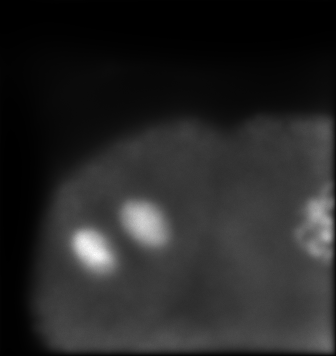

In [68]:
colorview(Gray, canal2_res[:,:,52]/maximum(canal2_res[:,:,52]))

In [78]:
@benchmark richardson_lucy_iterative2(image_stack2, ifftshift(psf_stack2), regularizer=nothing, iterations=50) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 20.715 s (0.00% GC) to evaluate,
 with a memory estimate of 380.45 MiB, over 136 allocations.

### Canal 3

In [12]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath3 = "/Users/yi/TFGNotebook/CElegans-FITC"
psfPath3 = "/Users/yi/TFGNotebook/PSF-CElegans-FITC"

# Cargar las imágenes en una matriz 3D
image_stack3 = load_image_stack(imagePath3)[1:356, 1:336, :]
psf_stack3 = load_image_stack(psfPath3)[179:534, 169:504, :] #mitad +152

#save("imagenOriginal_CANAL3.png", image_stack3[:, :,52]/maximum(image_stack3[:,:,52]))

# Verificar las dimensiones de las matrices 3D
println(size(image_stack3))
println("image_stack element type: ", eltype(image_stack3))
println(size(psf_stack3))

(356, 336, 104)
image_stack element type: Float32
(356, 336, 104)


In [13]:
canal3_res = richardson_lucy_iterative2(image_stack3, ifftshift(psf_stack3), regularizer=nothing, iterations=50);

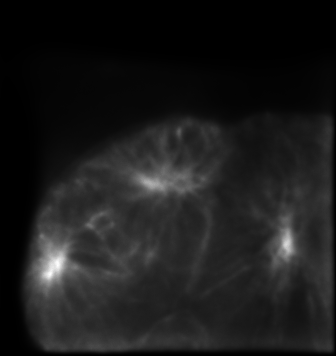

In [43]:
colorview(Gray, canal3_res[:,:,52]/maximum(canal3_res[:,:,52]))

In [14]:
save("Julia_CANAL3_50.png", canal3_res[:,:,52]/maximum(canal3_res[:,:,52]))

In [90]:
@benchmark richardson_lucy_iterative2(image_stack3, ifftshift(psf_stack3), regularizer=nothing, iterations=50) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 20.645 s (0.00% GC) to evaluate,
 with a memory estimate of 380.45 MiB, over 136 allocations.

### Combinación de canales

In [44]:
using Plots
using Images
using ColorTypes

In [45]:
# Función para normalizar una imagen
function normalize(image::AbstractArray)
    max_val = maximum(image)
    return (image) ./ (max_val)
end

normalize (generic function with 1 method)

In [46]:
# Normalizar los canales
deconvolved_stack_R = normalize(canal1_res)
deconvolved_stack_G = normalize(canal2_res)
deconvolved_stack_B = normalize(canal3_res)

356×336×104 Array{Float32, 3}:
[:, :, 1] =
 1.07083f-5   5.08558f-6   …  9.57981f-5  6.49643f-5  3.22747f-5
 3.3763f-6    2.07126f-6      1.7694f-5   1.27499f-5  7.85568f-6
 1.66197f-6   1.09939f-6      7.17363f-6  5.282f-6    3.46732f-6
 1.09045f-6   7.61467f-7      4.24008f-6  3.18286f-6  2.1436f-6
 7.86349f-7   5.42168f-7      2.78478f-6  2.11616f-6  1.49427f-6
 6.11724f-7   4.31907f-7   …  2.09927f-6  1.67404f-6  1.18798f-6
 5.3864f-7    3.76266f-7      1.80896f-6  1.44286f-6  1.02607f-6
 4.97822f-7   3.52857f-7      1.60296f-6  1.26465f-6  9.52608f-7
 5.1088f-7    3.57636f-7      1.63911f-6  1.3418f-6   9.50022f-7
 5.22301f-7   3.83814f-7      1.78486f-6  1.46679f-6  1.00679f-6
 ⋮                         ⋱                          ⋮
 0.00122312   0.000362529     0.0629174   0.0359987   0.0119003
 0.00116326   0.000339627     0.0632182   0.0367178   0.0115356
 0.00103468   0.000305138     0.0597778   0.0346509   0.0108168
 0.000916146  0.000266513  …  0.0567625   0.0318208   0.0100

In [47]:

# Crear una imagen RGB para la visualización
function create_rgb_image(r::AbstractArray, g::AbstractArray, b::AbstractArray)
    # Verificar que todas las dimensiones sean iguales
    height, width = size(r)
    if size(g) != (height, width) || size(b) != (height, width)
        throw(ArgumentError("Las dimensiones de las imágenes R, G y B deben coincidir."))
    end

    # Crear una matriz de imágenes RGB
    rgb_image = Array{RGB{Float32}, 2}(undef, height, width)
    rgb_image[:, :] .= RGB{Float32}[RGB(r[i, j], g[i, j], b[i, j]) for i in 1:height, j in 1:width]
    return rgb_image
end


create_rgb_image (generic function with 1 method)

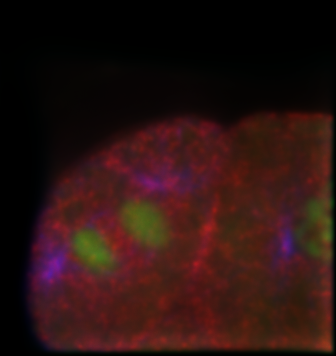

In [48]:

# Combinar los canales en una imagen RGB
deconvolved_image_color = create_rgb_image(deconvolved_stack_R[ :, :,52],
                                           deconvolved_stack_G[ :, :,52],
                                           deconvolved_stack_B[ :, :,52])


In [50]:

# Normalizar y combinar los planos para la visualización
original_image_rgb = create_rgb_image(normalize(image_stack[:, :, 52]),
                                       normalize(image_stack2[:, :,52]),
                                       normalize(image_stack3[:, :,52]))

# Guardar la imagen deconvolucionada en PNG
#save("deconvolved_CElegans_Julia.png", deconvolved_image_color)
#save("deconvolved_CElegans_Julia_CANAL1.png", deconvolved_stack_R[:, :,52])
# Mostrar las imágenes
plot(
    heatmap(original_image_rgb, title="Original", axis=false, color=:viridis),
    heatmap(deconvolved_image_color, title="Deconvolved", axis=false, color=:viridis),
    layout=(1, 2)
)

save("Julia_ImagenMejorada.png", deconvolved_image_color)
